# Request-Need Matching

In [41]:

import pandas as pd
import seaborn as sns
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [42]:
# read volunteer csv with pandas
df_volunteer = pd.read_csv('2019_Volunteers_Count_Report_clean.csv')
df_volunteer = df_volunteer[['Organization/ City Agency/ Division Name', 'Total Vounteers', "Organization Type", "Interest Areas"]]
df_volunteer = df_volunteer.rename(columns={"Organization/ City Agency/ Division Name": "Organization", "Total Vounteers": "Volunteers", "Organization Type": "Type", "Interest Areas": "Areas"})

In [43]:
df_volunteer

,Organization,Volunteers,Type,Areas
0,Hebrew Home at Riverdale,39,Article 28- Nursing Home Facility,Arts and culture
1,Choral Chameleon£¬Inc.,32,Arts Organization,Arts and culture
2,Administration for Children's Services,57,City agency,Arts and culture
3,Civic Engagement Commission,29,City agency,Arts and culture
4,New York City Housing Authority,4,City agency,Arts and culture
...,...,...,...,...
1132,Kissena Synergy,97,Volunteer-led group,Vulnerable group
1133,New York Junior League,600,Volunteer-led group,Vulnerable group
1134,Young Men Strong£¬LLC,4,Volunteer-led group£¬Does have for profit aspe...,Vulnerable group
1135,HeartShare Vulnerable group of NY,79,Volunteer-led group,Vulnerable group


In [44]:
# column_names = list(df_volunteer.columns)
column_names = ['Organization', 'Type', 'Areas']
print(column_names)

['Organization', 'Type', 'Areas']


In [45]:
df = df_volunteer
value = 'Volunteers'
# nx_graph = nx.from_pandas_edgelist(df, 'Organization', 'Type', ["Volunteers"])

nx_graph = nx.MultiDiGraph()
for node_type in column_names:
    nodes = df[node_type].unique()
    print(node_type, len(nodes))
    nx_graph.add_nodes_from(nodes, type=node_type)
for node in nx_graph.nodes:
    nx_graph.nodes[node][value] = 0.0

for index, entity in df.iterrows():
    for i in range(len(column_names)-1):
        nx_graph.add_edge(entity[column_names[i]], entity[column_names[i+1]], type=column_names[i], Volunteers=float(entity[value]))

Organization 495
Type 60
Areas 10


In [46]:
from_node = 'Organization'
to_node = 'Type'
value = 'Volunteers'

for index, entity in df.iterrows():
    nx_graph.nodes[entity[from_node]][value] = float(entity[value])
    # nx_graph.edges[entity[from_node], entity[to_node]][value] = float(entity[value].replace(',', ''))

# sum up the values of neighbors
for node_type in column_names:
    for node in [n for n,attrdict in nx_graph.nodes.items() if attrdict['type'] == node_type]:
        for u,v,k,d in nx_graph.in_edges(node, data=True, keys=True):
            nx_graph.nodes[node][value] += nx_graph.edges[u,v,k][value]
            # nx_graph.edges[edge][value] = nx_graph.nodes[edge[0]][value]/nx_graph.out_degree(edge[0])

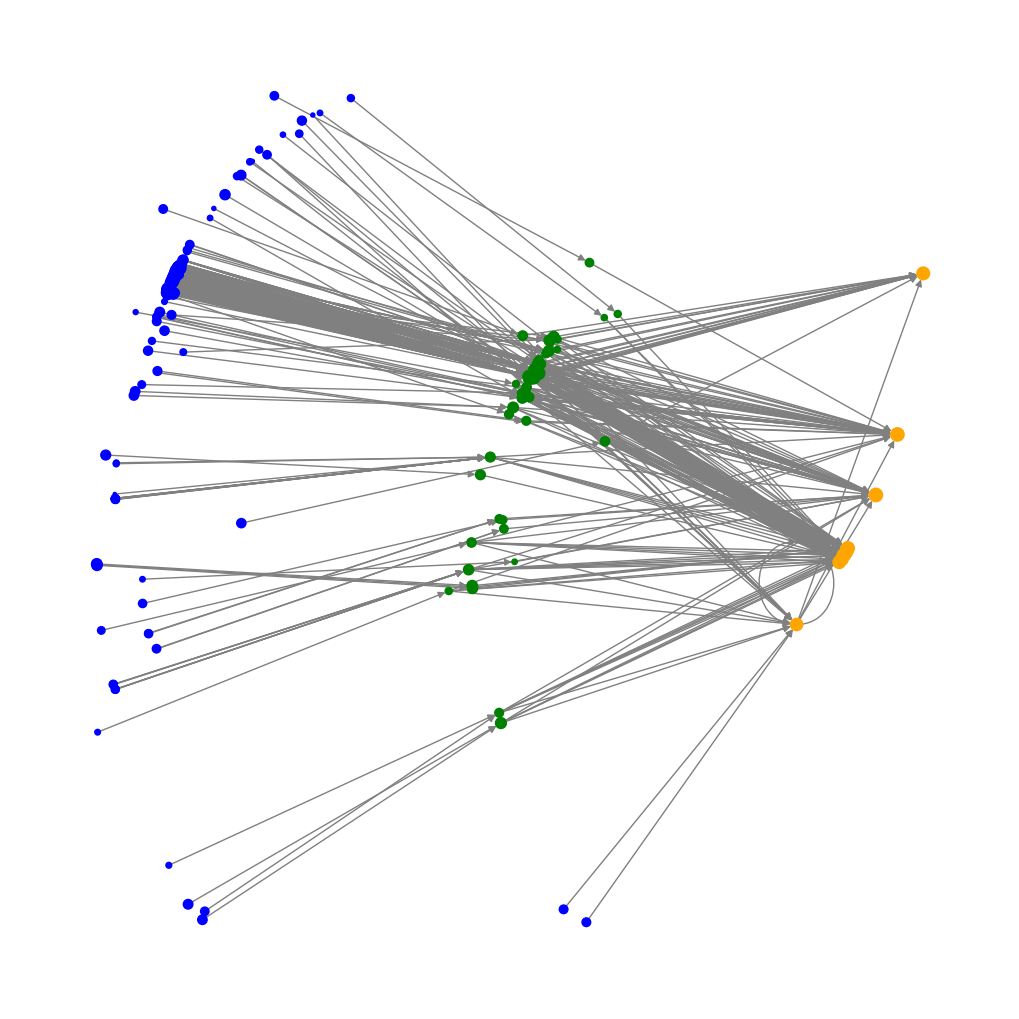

In [38]:
# draw graph
fig = plt.figure(figsize=(10, 10))

nx_graph = nx.DiGraph(nx_graph)

node_size = [nx_graph.nodes[n][value] for n in nx_graph.nodes]
# normalize node size with log2
node_size = [np.log2(x+1) for x in node_size]
node_size = [x/max(node_size)*100 for x in node_size]

column_colors_dict = {'Organization':'blue', 'Type':'green', 'Areas':'orange'}
node_color = [column_colors_dict[nx_graph.nodes[n]['type']] for n in nx_graph.nodes]


nx.draw(nx.DiGraph(nx_graph), pos=nx.kamada_kawai_layout(nx_graph, dim=2), node_size=node_size, node_color=node_color, with_labels=False, edge_color='grey')
# nx.draw(nx_graph)

In [47]:
len(nx_graph.edges)

2274

In [28]:
def norm_value_for_different_types(dict_data, value_key, type_key, type_list, use_log=False):
    type_data_dict = dict()
    for type in type_list:
        type_data = [dict_data[n][value_key] for n in dict_data if dict_data[n][type_key] == type]
        type_data_dict[type] = np.array(type_data)

    # normalize the data
    for type in type_list:
        type_data_dict[type] = (type_data_dict[type]-min(type_data_dict[type]))
        type_data_dict[type] = type_data_dict[type]/max(type_data_dict[type])
        if use_log:
            type_data_dict[type] = np.log2(type_data_dict[type]+1)
        

    # assign the normalized data back to dict data
    type_index = {type:0 for type in type_list}
    for type in type_list:
        for n in dict_data:
            if dict_data[n][type_key] == type:
                dict_data[n][value_key] = type_data_dict[type][type_index[type]]
                type_index[type] += 1

    return dict_data

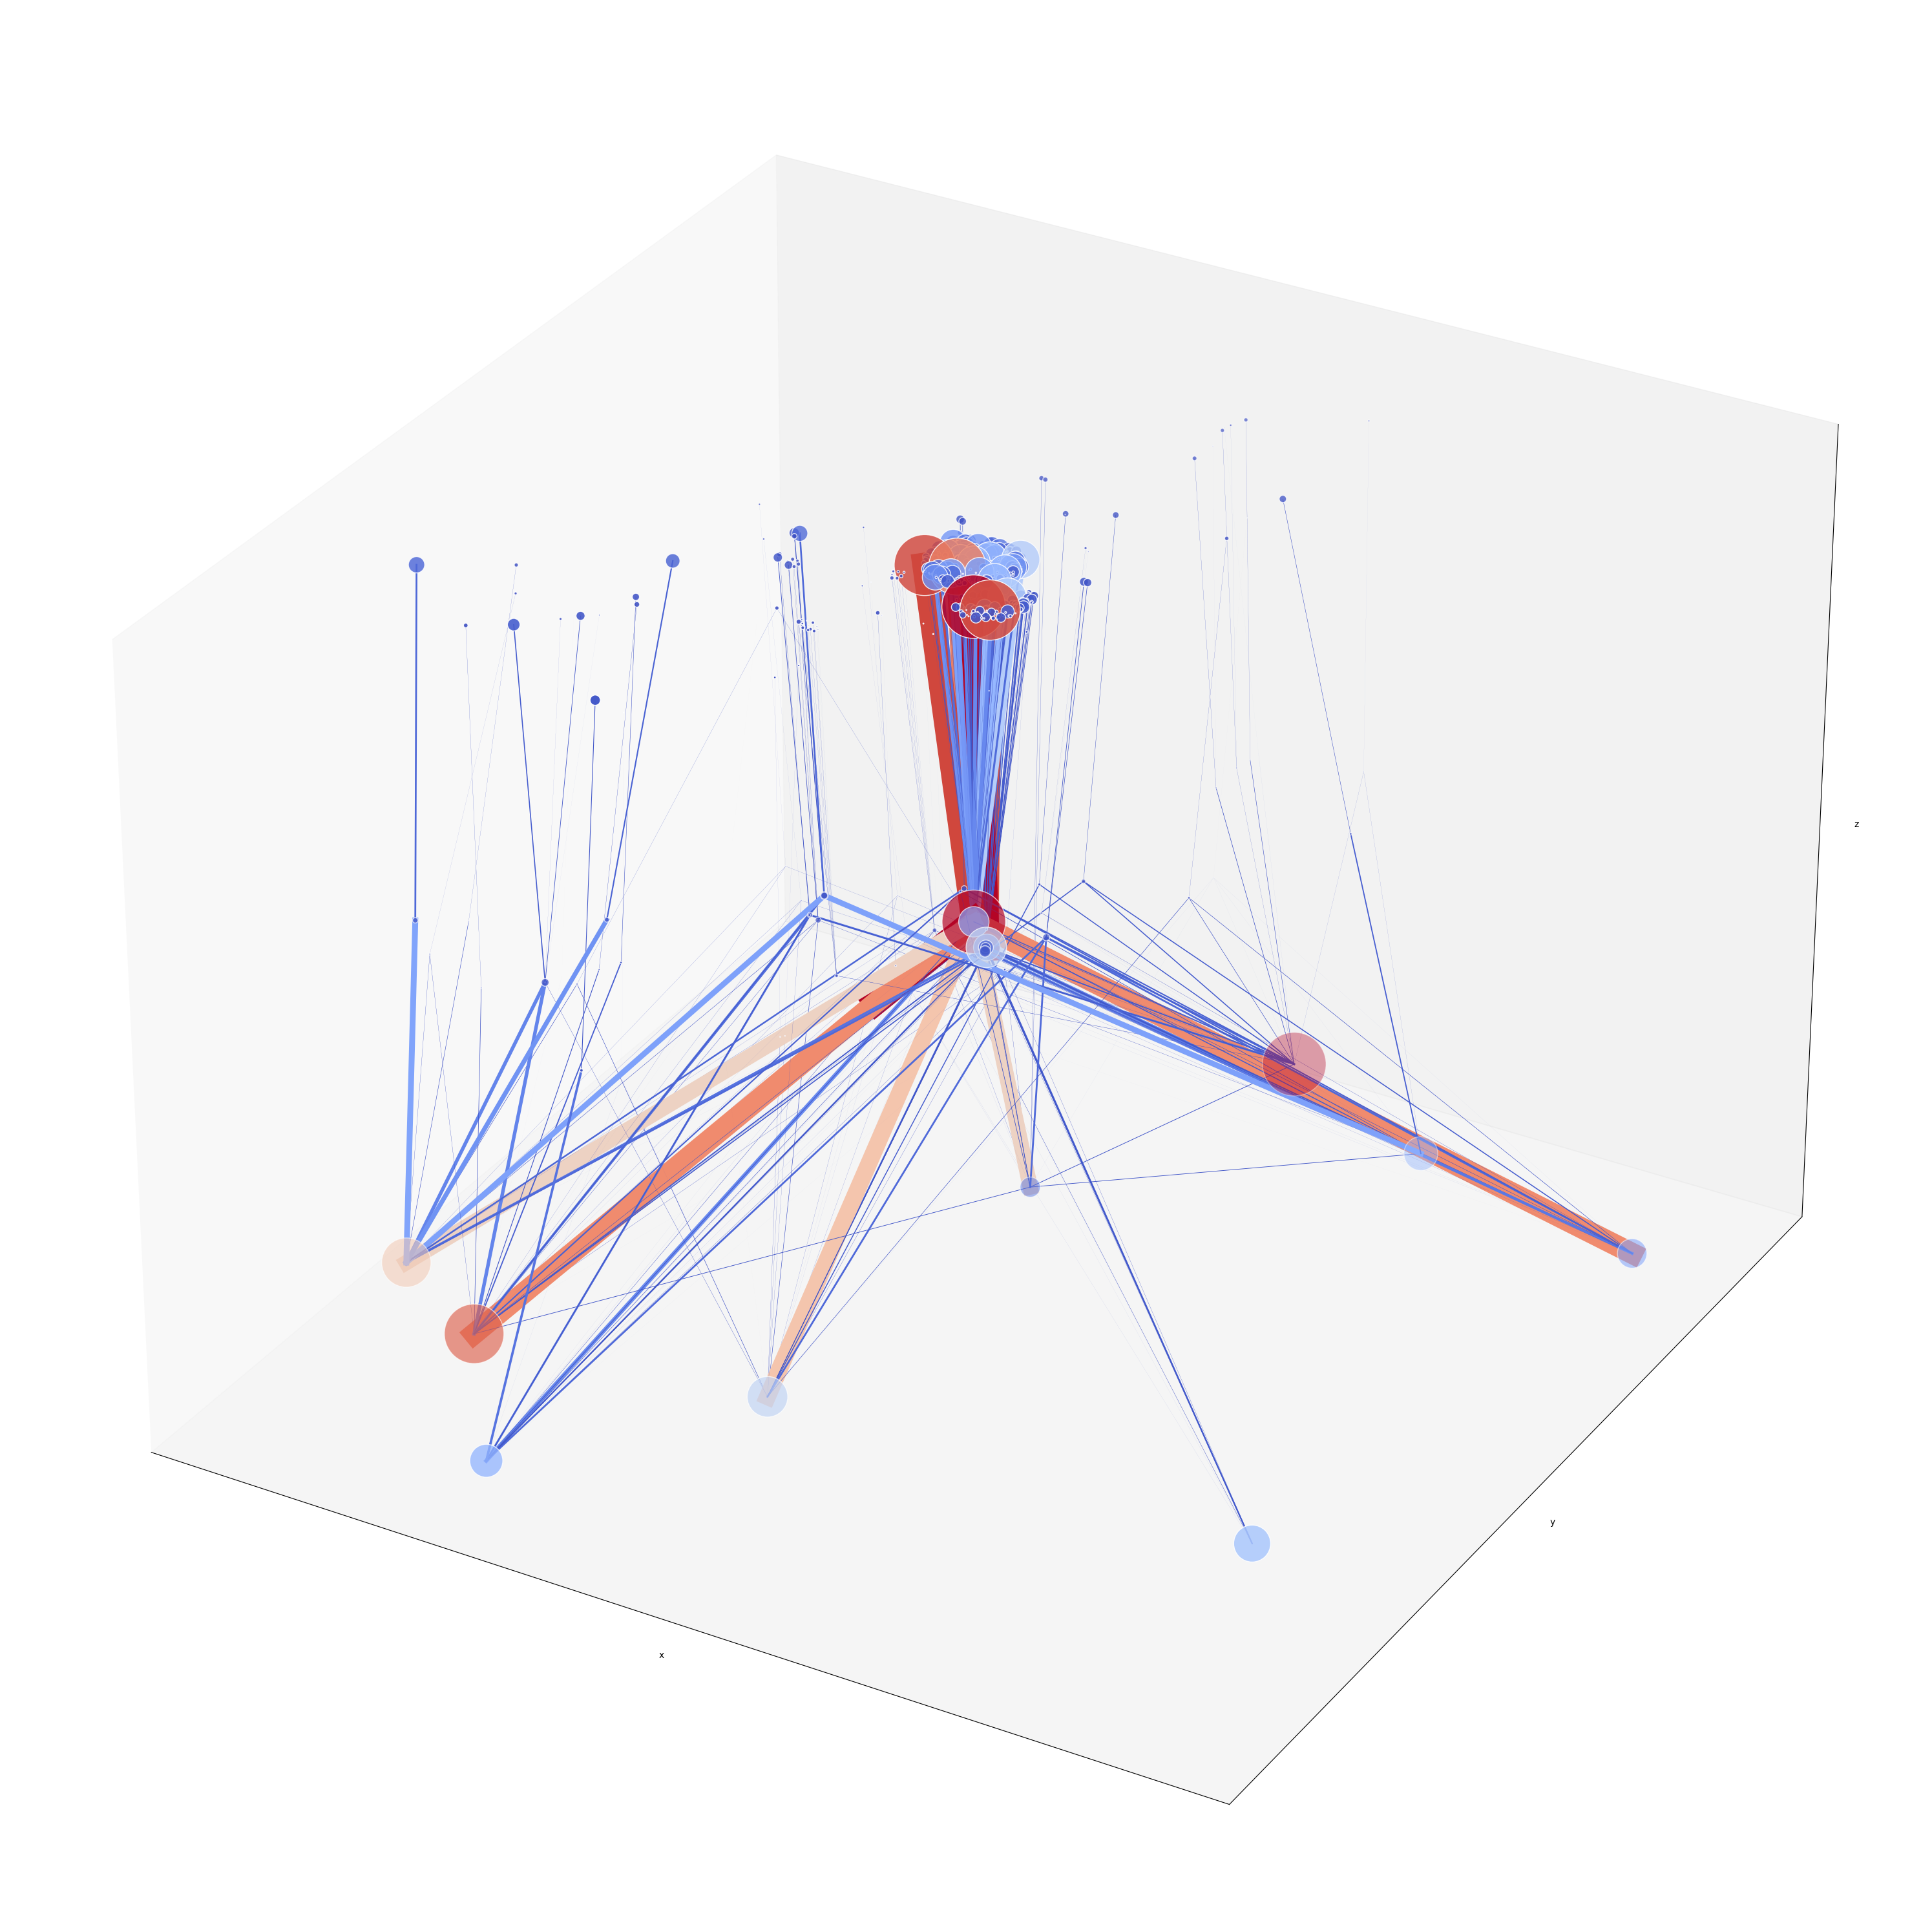

In [29]:
G = nx_graph.copy()

G = nx.DiGraph(G)

G = nx.convert_node_labels_to_integers(G, first_label=0, ordering='increasing degree', label_attribute=None)

# 3d spring layout
pos = nx.spring_layout(G, dim=3, seed=0)

for node, coords in pos.items():
    if G.nodes[node]['type'] == 'Organization':
        coords[2] = 2
    elif G.nodes[node]['type'] == 'Type':
        coords[2] = 0
    elif G.nodes[node]['type'] == 'Areas':
        coords[2] = -2

# Extract node and edge positions from the layout
node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

# set node color and size
node_value_dict = dict(G.nodes(data=True))
norm_node_value_dict = norm_value_for_different_types(node_value_dict, value, 'type', column_names, use_log=True)
node_size = np.array([norm_node_value_dict[n][value] for n in sorted(G)])*5000

norm_node_value_dict = norm_value_for_different_types(node_value_dict, value, 'type', column_names)
node_color = [norm_node_value_dict[n][value] for n in sorted(G)]
node_color = plt.cm.coolwarm(node_color)

# set edge color and size
edge_value_dict = {(n0,n1):v for n0,n1,v in G.edges(data=True)}
norm_edge_value_dict = norm_value_for_different_types(edge_value_dict, value, 'type', column_names[:-1], use_log=True)
edge_size = np.array([norm_edge_value_dict[e][value] for e in G.edges()])*30

norm_edge_value_dict = norm_value_for_different_types(edge_value_dict, value, 'type', column_names[:-1])
edge_color = [norm_edge_value_dict[e][value] for e in G.edges()]
edge_color = plt.cm.coolwarm(edge_color)

# Create the 3D figure
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111, projection='3d')

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=node_size, c=node_color, ec="w")

# Plot the edges
for vizedge, size, color in zip(edge_xyz, edge_size, edge_color):
    ax.plot(*vizedge.T, color=color, linewidth=size)


def _format_axes(ax):
    """Visualization options for the 3D axes."""
    # Turn gridlines off
    ax.grid(False)
    # Suppress tick labels
    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])
    # Set axes labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

_format_axes(ax)
fig.tight_layout()

plt.show()

In [30]:
nx_graph.nodes['Health']
nx_graph.edges

OutMultiEdgeView([('Hebrew Home at Riverdale', 'Article 28- Nursing Home Facility', 0), ('Hebrew Home at Riverdale', 'Article 28- Nursing Home Facility', 1), ('Hebrew Home at Riverdale', 'Article 28- Nursing Home Facility', 2), ('Hebrew Home at Riverdale', 'Article 28- Nursing Home Facility', 3), ('Hebrew Home at Riverdale', 'Article 28- Nursing Home Facility', 4), ('Hebrew Home at Riverdale', 'Article 28- Nursing Home Facility', 5), ('Hebrew Home at Riverdale', 'Article 28- Nursing Home Facility', 6), ('Choral Chameleon£¬Inc.', 'Arts Organization', 0), ("Administration for Children's Services", 'City agency', 0), ("Administration for Children's Services", 'City agency', 1), ("Administration for Children's Services", 'City agency', 2), ("Administration for Children's Services", 'City agency', 3), ("Administration for Children's Services", 'City agency', 4), ('Civic Engagement Commission', 'City agency', 0), ('New York City Housing Authority', 'City agency', 0), ('New York City Housing 